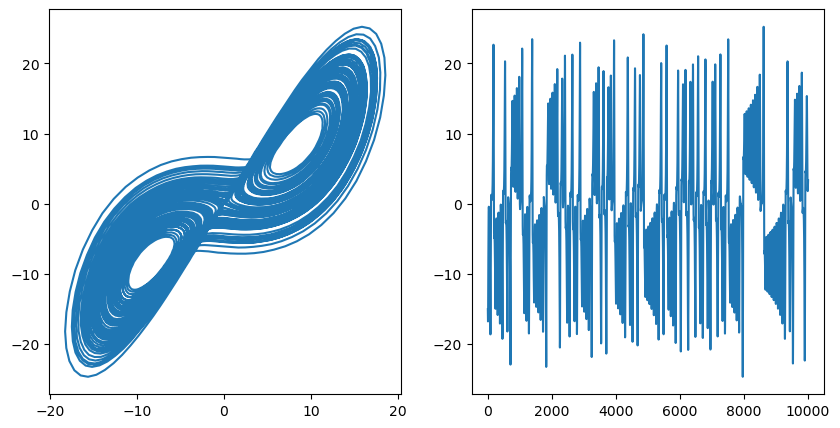

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import embed_signal_torch
import torch

%load_ext autoreload
%autoreload 2
from dysts.flows import Lorenz
from utils import train, make_dataset

## Load and simulate an attractor
model = Lorenz()
model.dt = 0.01
noise = 0.01
sol = model.make_trajectory(10000, resample=False, noise=0.0)

sol += np.random.normal(0, noise, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:, 1])

In [2]:
data = sol[:, 0:1]
var = np.var(data)
std = np.std(data)
var, std

(61.790996161389465, 7.860724913224573)

In [30]:
from sklearn.neighbors import NearestNeighbors


def find_neighbors(embedding, n_neighbors, algorithm="ball_tree"):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm).fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    indices = indices[:, 1:]  # exclude present point
    return distances, indices


def compute_EkT(data, embedding, n_neighbors, T, thresh=10):
    # data should be 1 dimensional in the last axis
    if data.ndim == 3:
        print("multiple trajectories found, recursing")
        E_kT = []
        for i in range(data.shape[0]):
            E_kT.extend(compute_EkT(data[i], embedding[i], n_neighbors, T))
        return E_kT

    if T < thresh:
        data = data[
            : T - thresh
        ]  # remove the last thresh-T points to keep array size consistent
        embedding = embedding[: T - thresh]
    # trajs has shape (time ,dim)
    d = embedding[:-T]  # can't look at the last T
    _, indices = find_neighbors(d, n_neighbors)
    # now given the indices, we need to find the index of the point T steps after the point of a given index
    data = data[T:]
    # calculate the mean of these points for each point d
    mu_kT = np.mean(
        data[indices], axis=1
    )  # * (n_neighbors - 1) / (n_neighbors) #unbias
    # calculate the variance of the neighborsfor each of the points d
    mu_kT = mu_kT[:, np.newaxis].repeat(n_neighbors - 1, axis=1)

    E_kT = np.mean((data[indices] - mu_kT) ** 2, axis=(1, 2))  # shape (time)

    norm = (n_neighbors - 1) / n_neighbors  # rescale
    E_kT *= norm
    return E_kT


def compute_Ek(data, embedding, n_neighbors, max_T):
    E_k = []
    for T in range(1, max_T + 1):
        E_kT = compute_EkT(data, embedding, n_neighbors, T, thresh=max_T)
        E_k.append(E_kT)

    E_k = np.array(E_k)
    E_k = np.mean(E_k, axis=0)
    return E_k


def compute_eps_k(embedding, n_neighbors, thresh=10):
    if embedding.ndim == 3:
        embedding = embedding[
            :, :-thresh
        ]  # pick the data to go along with the E_k cutoff (can't look at the last T points because we need to look T steps ahead)
        embedding = embedding.reshape(-1, embedding.shape[-1])
    else:
        embedding = embedding[:-thresh]

    distances, _ = find_neighbors(embedding, n_neighbors)

    # fact = 2 / (n_neighbors * (n_neighbors - 1))
    # this is not quite correct--need to calculate the distance between all elements in the neighborhood

    eps_k = np.sum(distances[:, 1:] ** 2, axis=1)  # * fact

    norm_factor = 1 / np.mean(1 / eps_k)
    eps_k /= distances.shape[1]
    eps_k *= 2

    return eps_k, norm_factor


def compute_noise_amp_k(
    data, embedding, n_neighbors, max_T, noise_res=0.0, normalize=False
):
    if noise_res >= 0:
        embedding += np.random.uniform(-noise_res, noise_res, embedding.shape)

    E_k = compute_Ek(data, embedding, n_neighbors + 1, max_T)

    eps_k, norm_factor = compute_eps_k(embedding, n_neighbors + 1, max_T)

    sig = np.mean(E_k / eps_k)
    if normalize:
        sig *= norm_factor

    return sig, E_k, eps_k

In [48]:
ndelays = 60
tau = 10
H = np.array(embed_signal_torch(data, ndelays, tau))
data_cut = data[(ndelays - 1) * tau :]
H.shape, data_cut.shape

((9410, 60), (9410, 1))

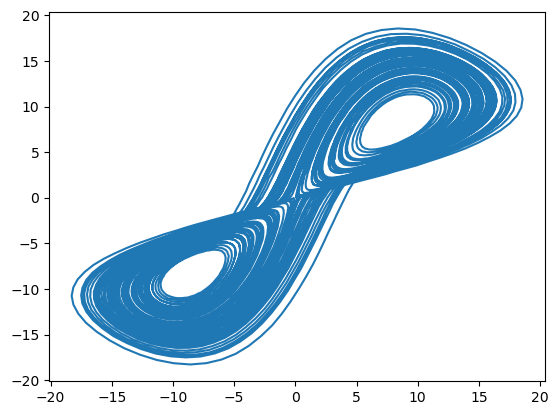

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
red = pca.fit_transform(H)

plt.plot(H[:, 0], H[:, 1])

In [32]:
nk = 3
sigs = []
eks = []
eps_ks = []
# this should saturate to data variance
for nT in range(1, 3001, 500):
    sigma, ek, eps_k = compute_noise_amp_k(data_cut, H, nk, nT, normalize=True)
    sigs.append(sigma)
    eks.append(ek.mean())
    eps_ks.append(eps_k.mean())
    print(sigma)

0.03419238487735135
33.32014457911637
44.41720839882318
49.29478262402618
52.57387931406769
53.52348031238636


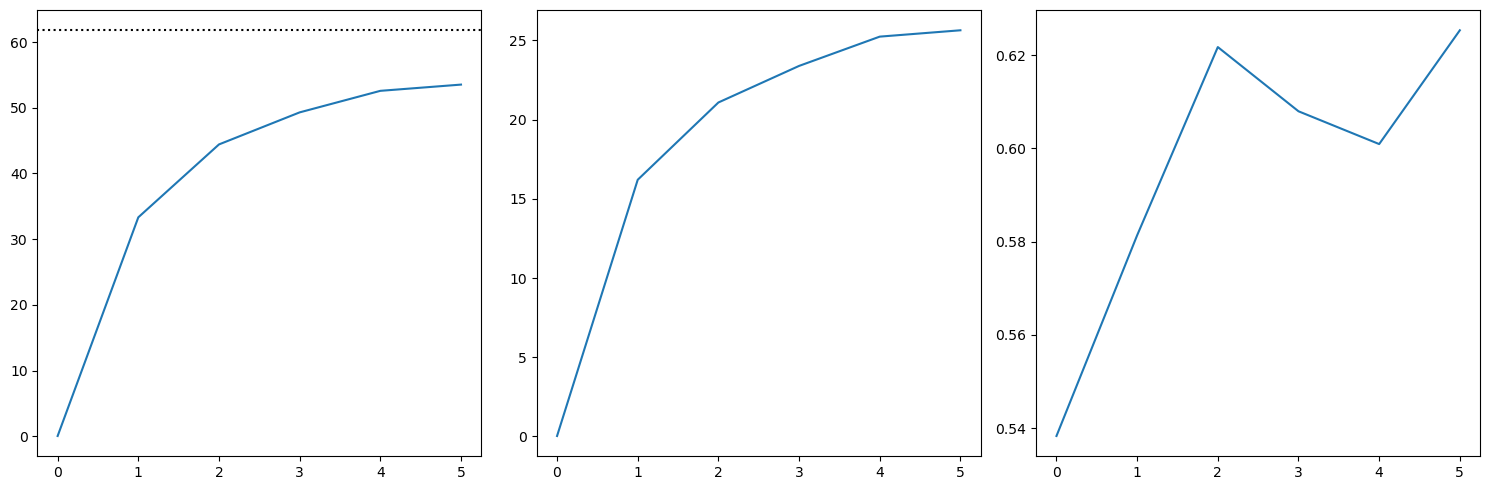

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(sigs, label="sig")
ax[0].axhline(var, linestyle=":", c="k")
ax[1].plot(eks, label="E_k")
ax[2].plot(eps_ks, label="eps_k")
# plt.legend()
plt.tight_layout()

In [60]:
nk = 4
nT = 20
sigma, ek, eps_k = compute_noise_amp_k(data, H, nk, nT, normalize=True)
sigma, np.mean(ek), np.mean(eps_k)

KeyboardInterrupt: 

In [61]:
nk = 4
nT = 20
ndelays = np.arange(5, 65, 5)
taus = [1, 2, 5, 10]
epss = []
eks = []
sigmas = []
for tau in taus:
    ss = []
    ee = []
    pp = []
    for ndelay in ndelays:
        print(ndelay)

        H = np.array(embed_signal_torch(data, ndelay, tau))
        sigma, ek, eps = compute_noise_amp_k(data, H, nk, nT, normalize=True)
        ss.append(sigma)
        ee.append(np.mean(ek))
        pp.append(np.mean(eps))

    epss.append(pp)
    eks
    sigmas.append(ss)

5
10
15
20
25
30
35
40
45
50
55
60
5
10
15
20
25
30
35
40
45
50
55
60
5
10
15
20
25
30
35
40
45
50
55
60
5
10
15
20
25
30
35
40
45
50
55
60


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


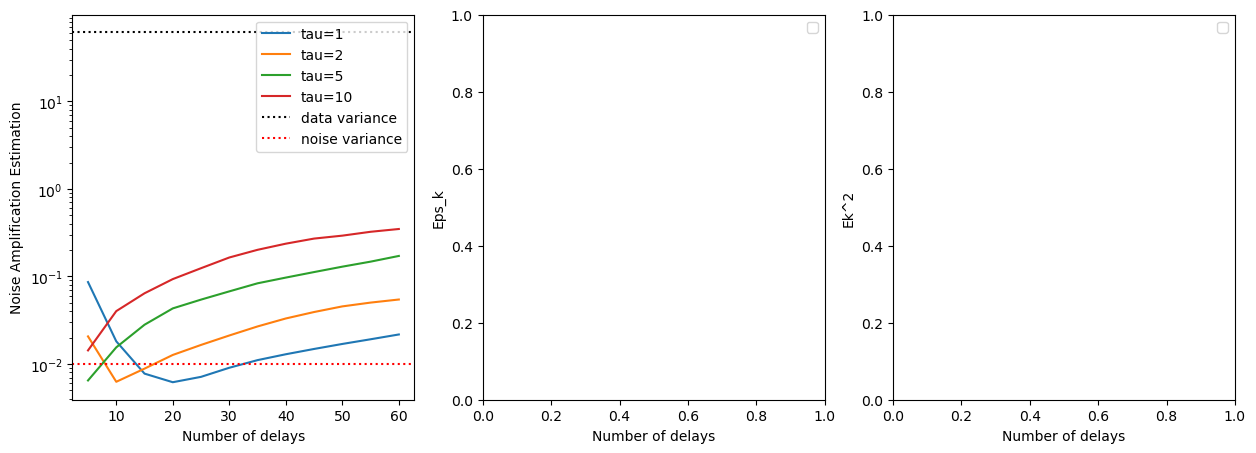

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, tau in enumerate(taus):
    ax[0].plot(ndelays, sigmas[i], label=f"tau={tau}")
    # ax[1].plot(ndelays, epss[i], label=f"tau={tau}")
    # ax[2].plot(ndelays,eks[i],label=f"tau={tau}")
ax[0].axhline(var, label="data variance", c="k", linestyle=":")
ax[0].axhline(noise, label="noise variance", c="r", linestyle=":")
ax[0].set_yscale("log")
ax[0].set_ylabel("Noise Amplification Estimation")
ax[1].set_ylabel("Eps_k")
ax[2].set_ylabel("Ek^2")
for i in range(3):
    ax[i].set_xlabel("Number of delays")
    ax[i].legend()

In [43]:
ndelays = np.arange(5, 105, 5)
taus = np.arange(1, 11, 1)
sigmas = np.zeros((ndelays.size, taus.size))
eps_ks = np.zeros((ndelays.size, taus.size))
for i, nd in enumerate(ndelays):
    for j, tau in enumerate(taus):
        print(nd, tau)

        H = np.array(embed_signal_torch(data, nd, tau))
        sig, _, eps_k = compute_noise_amp_k(H, nk, nT)

        sigmas[i, j] = sig
        eps_ks[i, j] = eps_k

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
25 1
25 2
25 3
25 4
25 5
25 6
25 7
25 8
25 9
25 10
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
40 1
40 2
40 3
40 4
40 5
40 6
40 7
40 8
40 9
40 10
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
50 10
55 1
55 2
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
60 1
60 2
60 3
60 4
60 5
60 6
60 7
60 8
60 9
60 10
65 1
65 2
65 3
65 4
65 5
65 6
65 7
65 8
65 9
65 10
70 1
70 2
70 3
70 4
70 5
70 6
70 7
70 8
70 9
70 10
75 1
75 2
75 3
75 4
75 5
75 6
75 7
75 8
75 9
75 10
80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
85 1
85 2
85 3
85 4
85 5
85 6
85 7
85 8
85 9
85 10
90 1


KeyboardInterrupt: 

Text(0, 0.5, 'ndelays')

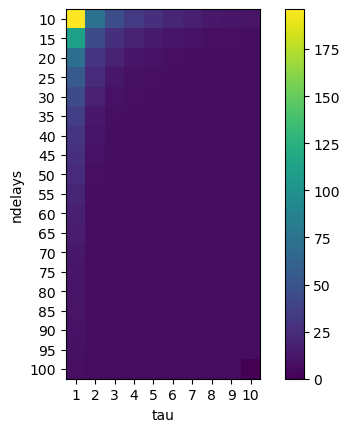

In [41]:
plt.imshow(sigmas[1:])
# add relevant ticks and labels from above
plt.xticks(np.arange(taus.size), taus)
plt.yticks(np.arange(ndelays.size - 1), ndelays[1:])
plt.colorbar()
plt.xlabel("tau")
plt.ylabel("ndelays")